### Import Libraries and Define Functions

In [1]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

### Load Data

Our data is from a matlab file, so we need to import it and understand the format.

In [3]:
# import data and check the type
mat = scipy.io.loadmat('traffic_dataset.mat')
print(type(mat))

mat

<class 'dict'>


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Mar 14 15:49:14 2020',
 '__version__': '1.0',
 '__globals__': [],
 'tra_X_tr': array([[<36x48 sparse matrix of type '<class 'numpy.float64'>'
         	with 540 stored elements in Compressed Sparse Column format>,
         <36x48 sparse matrix of type '<class 'numpy.float64'>'
         	with 540 stored elements in Compressed Sparse Column format>,
         <36x48 sparse matrix of type '<class 'numpy.float64'>'
         	with 540 stored elements in Compressed Sparse Column format>,
         ...,
         <36x48 sparse matrix of type '<class 'numpy.float64'>'
         	with 540 stored elements in Compressed Sparse Column format>,
         <36x48 sparse matrix of type '<class 'numpy.float64'>'
         	with 540 stored elements in Compressed Sparse Column format>,
         <36x48 sparse matrix of type '<class 'numpy.float64'>'
         	with 540 stored elements in Compressed Sparse Column format>]],
       dtype=obje

Our data has already been split into test and train data. We will use the same, but will unpack the data.

In [4]:
print('Training Labels Shape:', mat['tra_Y_tr'][0].shape)
print('Training Features Shape:', mat['tra_X_tr'][0].shape)
print('Test Labels Shape:', mat['tra_Y_te'][0].shape)
print('Test Features Shape:', mat['tra_X_te'][0].shape)

Training Labels Shape: (1261,)
Training Features Shape: (1261,)
Test Labels Shape: (840,)
Test Features Shape: (840,)


In [5]:
mat['tra_X_tr'][0][0]

<36x48 sparse matrix of type '<class 'numpy.float64'>'
	with 540 stored elements in Compressed Sparse Column format>

In [6]:
mat['tra_Y_tr']

array([[0.05091079, 0.04764129, 0.04483886, ..., 0.37132181, 0.42456796,
        0.42269967],
       [0.04624007, 0.04950957, 0.052312  , ..., 0.37085474, 0.43811303,
        0.50116768],
       [0.05044372, 0.04437179, 0.05044372, ..., 0.25502102, 0.40168146,
        0.37926203],
       ...,
       [0.02709014, 0.01868286, 0.02568893, ..., 0.10322279, 0.13872022,
        0.1424568 ],
       [0.03409622, 0.02195236, 0.03549743, ..., 0.15787015, 0.20364316,
        0.21064923],
       [0.04063522, 0.02989257, 0.05651565, ..., 0.91032228, 0.75198505,
        0.83839327]])

The feature data is in sparse matrix format, so we need to reformat it to work with our models.

In [7]:
# reformat data for use in our models
X_train = mat['tra_X_tr'][0]
X_train = [i.todense() for i in X_train]
X_train = np.array(X_train)

y_train = mat['tra_Y_tr']
y_train = y_train.T

X_test = mat['tra_X_te'][0]
X_test = [i.todense() for i in X_test]
X_test = np.array(X_test)

y_test = mat['tra_Y_te']
y_test = y_test.T

### Exploratory Data Analysis



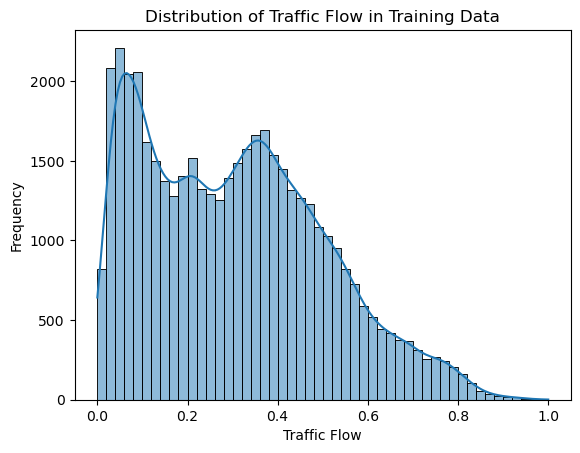

In [8]:
# Visualize the distribution of traffic flow in the training set using a histogram
sns.histplot(y_train.flatten(), bins=50, kde=True)
plt.title('Distribution of Traffic Flow in Training Data')
plt.xlabel('Traffic Flow')
plt.ylabel('Frequency')
plt.show()

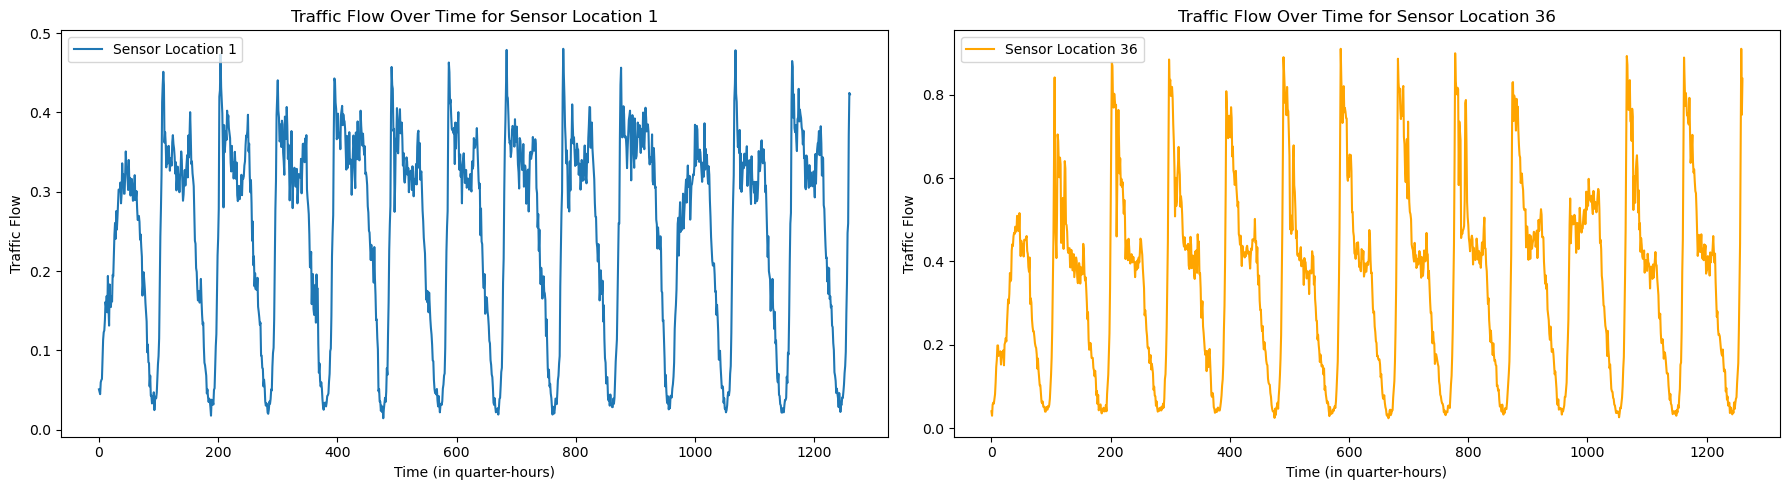

In [9]:
# Plot the traffic flows for a couple of sensor locations over time
# Choose the first and the last sensor locations
plt.figure(figsize=(18, 5))

# Plotting traffic flow for the first sensor location
plt.subplot(1, 2, 1)
plt.plot(y_train[:,0].T, label='Sensor Location 1')
plt.title('Traffic Flow Over Time for Sensor Location 1')
plt.xlabel('Time (in quarter-hours)')
plt.ylabel('Traffic Flow')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_train[:,-1].T, label='Sensor Location 36', color='orange')
plt.title('Traffic Flow Over Time for Sensor Location 36')
plt.xlabel('Time (in quarter-hours)')
plt.ylabel('Traffic Flow')
plt.legend()

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Traffic Flow Over Time (Training Set)')

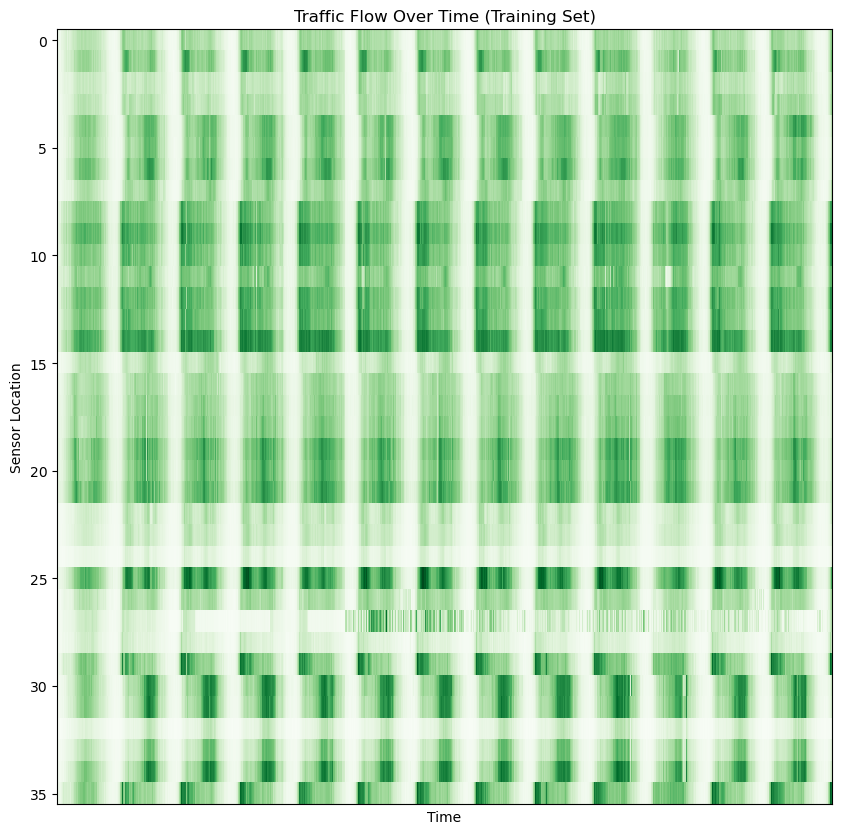

In [10]:
# Visualize traffic patterns across all sensor locations

fig = plt.figure(figsize=(10,10), num=1)
plt.matshow(y_train.T, fignum=1, aspect='auto',
            cmap='Greens')

plt.ylabel('Sensor Location')
plt.xlabel('Time')
plt.xticks(ticks=[])
plt.title('Traffic Flow Over Time (Training Set)')

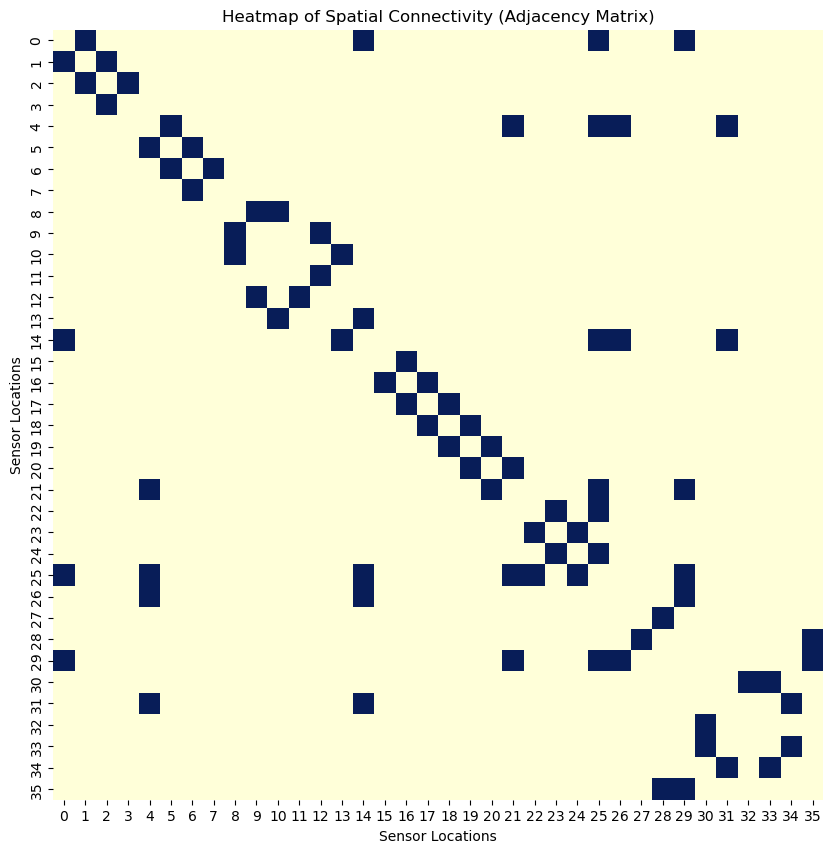

In [11]:
# Visualize the adjacency matrix using a heatmap to see the connectivity pattern
adj_mat = mat['tra_adj_mat']
fig = plt.figure(figsize=(10,10), num=1)
sns.heatmap(adj_mat, cmap="YlGnBu",
             square=True,
             cbar=False)

plt.title('Heatmap of Spatial Connectivity (Adjacency Matrix)')
plt.xlabel('Sensor Locations')
plt.ylabel('Sensor Locations')
plt.show()

These plots show that the traffic flow at each sensor location is cyclical, and that they are located nearby to eachother. We may be able to leverage the adjacency of each sensor in order to develop a more accurate model.

### Baseline Model

For the baseline model, we will calculate the mean traffic flow for each sensor location and use that as our predictions.

In [12]:
means = y_train.mean(axis=0)

base_predicted_train = np.tile(means, (len(X_train),1))
base_predicted_test = np.tile(means, (len(X_test),1))

# calculate the mean absolute error for the baseline model
mse_train = ((y_train - base_predicted_train)**2).sum()/len(X_train)
mse_test = ((y_test - base_predicted_test)**2).sum()/len(X_test)


print('Baseline training mean squared error:', mse_train)
print('Baseline test mean squared error:', mse_test)

Baseline training mean squared error: 1.0769911936983292
Baseline test mean squared error: 1.1275430633903811


### Linear Regression Model

In [13]:
X_train_lin = np.array([X_train[i].flatten() for i in range(len(X_train))])
X_test_lin = np.array([X_test[i].flatten() for i in range(len(X_test))])


# Split training data
X_train_lin, X_val, y_train_lin, y_val = train_test_split(X_train_lin, y_train, test_size=0.1, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train_lin, y_train_lin)

# Create predictions for train and test data
train_pred = lin_reg.predict(X_train_lin)
val_pred = lin_reg.predict(X_val)
test_pred = lin_reg.predict(X_test_lin)

# Calculate loss for training
training_mse = mean_squared_error(y_train_lin, train_pred)
print(f"Training loss: {training_mse}")

# Calculate loss on the validation set
validation_mse = mean_squared_error(y_val, val_pred)
print(f"Validation loss: {validation_mse}")

# Calculate test loss
testing_mse = mean_squared_error(y_test, test_pred)
print(f"Test loss: {testing_mse}")

Training loss: 0.000756952074292297
Validation loss: 0.001721127023229946
Test loss: 0.004076647793954822


### Single Layer NN

In [14]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(36, 48)),
        tf.keras.layers.Dense(36, activation=None)      
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

Epoch 1/10
 1/36 [..............................] - ETA: 5s - loss: 0.8209

2024-04-16 19:36:05.454328: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


36/36 [==============================] - 0s 2ms/step - loss: 0.1034 - val_loss: 0.0078
Epoch 2/10
36/36 [==============================] - 0s 866us/step - loss: 0.0059 - val_loss: 0.0033
Epoch 3/10
36/36 [==============================] - 0s 837us/step - loss: 0.0037 - val_loss: 0.0024
Epoch 4/10
36/36 [==============================] - 0s 827us/step - loss: 0.0034 - val_loss: 0.0025
Epoch 5/10
36/36 [==============================] - 0s 796us/step - loss: 0.0030 - val_loss: 0.0026
Epoch 6/10
36/36 [==============================] - 0s 799us/step - loss: 0.0030 - val_loss: 0.0024
Epoch 7/10
36/36 [==============================] - 0s 781us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 8/10
36/36 [==============================] - 0s 823us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 9/10
36/36 [==============================] - 0s 790us/step - loss: 0.0030 - val_loss: 0.0026
Epoch 10/10
27/27 [==============================] - 0s 355us/step - loss: 0.0042
Test Loss: 0.004164794459939003

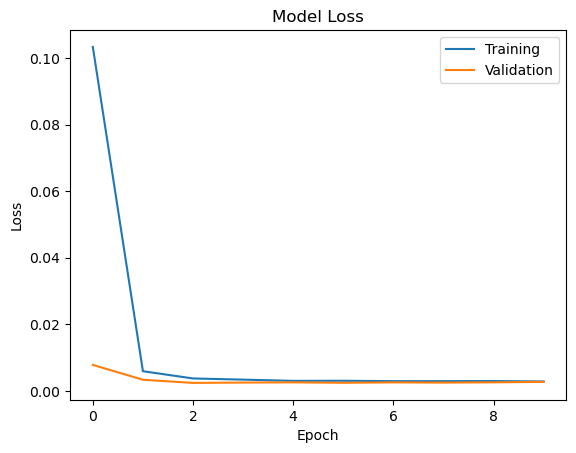

In [15]:
model = create_model()

# Training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

#Plotting
print("Test Loss:", test_loss)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Multilayer NN and Hyperparameter tuning

In [16]:
def build_model(hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  
  # Each X is 36x48
  model.add(tf.keras.layers.Flatten(input_shape=[36,48], name='Input'))
  for hidden_layer in hidden_layer_sizes:
    model.add(tf.keras.layers.Dense(hidden_layer,
                                    activation=activation))
  model.add(tf.keras.layers.Dense(36, name='Output'))
  
  if optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

  model.compile(loss='mean_squared_error',
                optimizer=opt,
                metrics=['accuracy'])

  return model

### Hyperparameter Tuning

First, we vary the activation function and optimizer. Next, we will add hidden layers and vary the quantity and size.

In [17]:
# repeat for every test
model = build_model(hidden_layer_sizes=[256, 128, 64], activation='relu', optimizer='Adam', learning_rate=0.001)

In [18]:
# train the model and store the loss/accuracy
history = model.fit(
    X_train,
    y_train, 
    epochs=50,
    validation_split=0.2)

Epoch 1/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0504 - accuracy: 0.1399 - val_loss: 0.0110 - val_accuracy: 0.2727
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 0.3274 - val_loss: 0.0060 - val_accuracy: 0.3518
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.3641 - val_loss: 0.0045 - val_accuracy: 0.3320
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.4306 - val_loss: 0.0034 - val_accuracy: 0.4387
Epoch 5/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - accuracy: 0.4821 - val_loss: 0.0029 - val_accuracy: 0.5257
Epoch 6/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.5040 - val_loss: 0.0027 - val_accuracy: 0.5336
Epoch 7/50
32/32 [==============================] - 0s 2ms/step - loss: 0.0029 - accuracy: 0.4990 - val_loss: 0.0030 - val_accuracy: 0.5455
Epoch 8/50
32/32 [==

Text(0.5, 1.0, 'Mean Absolute Error')

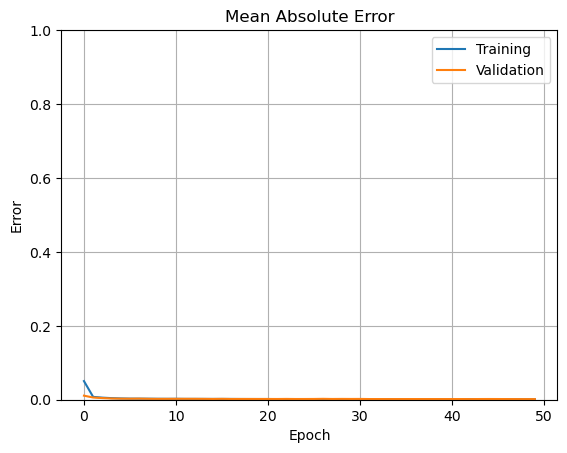

In [19]:
plot_loss(history=history)
plt.title('Mean Absolute Error')

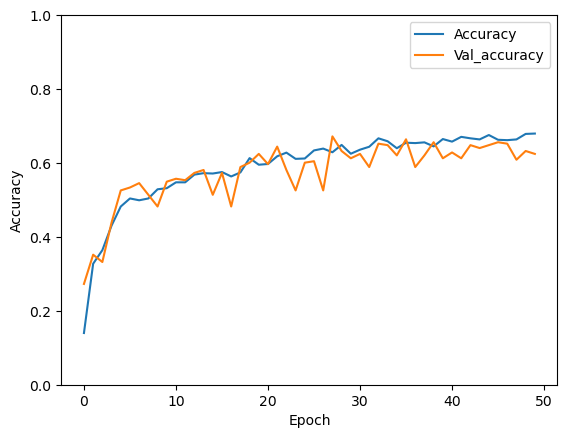

In [20]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_accuracy')

plt.legend()
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.show()

In [21]:
y_pred = model.predict(X_test)

27/27 [==============================] - 0s 597us/step


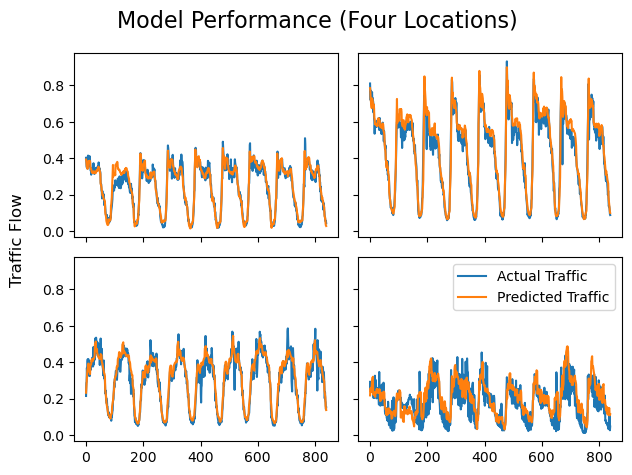

In [22]:
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)

ax = axs[0][0]
ax.plot(y_test.T[0], label='Actual Traffic')
ax.plot(y_pred.T[0], label='Predicted Traffic')

ax = axs[0][1]
ax.plot(y_test.T[9], label='Actual Traffic')
ax.plot(y_pred.T[9], label='Predicted Traffic')

ax = axs[1][0]
ax.plot(y_test.T[18], label='Actual Traffic')
ax.plot(y_pred.T[18], label='Predicted Traffic')

ax = axs[1][1]
ax.plot(y_test.T[27], label='Actual Traffic')
ax.plot(y_pred.T[27], label='Predicted Traffic')

plt.legend()
fig.suptitle('Model Performance (Four Locations)', size=16)
fig.supylabel('Traffic Flow')
fig.subplots_adjust(top=0.88)
fig.tight_layout()

In [23]:
test_loss = model.evaluate(x=X_test, y=y_test, verbose=0,
                                 return_dict=True)['loss']
print(test_loss)

0.002522804541513324


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Flatten)             (None, 1728)              0         
                                                                 
 dense (Dense)               (None, 256)               442624    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 Output (Dense)              (None, 36)                2340      
                                                                 
Total params: 486,116
Trainable params: 486,116
Non-trainable params: 0
_________________________________________________________________


HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-
[]|relu|SGD|0.01| 62244 | 0.320
[]|tanh|SGD|0.01| 62244 | 0.223
[]|relu|Adam|0.01| 62244 | 0.146
[128]|relu|Adam|0.01| 225956 | 0.227
[256,128]|relu|Adam|0.01| 480164 | 0.573
[256,128, 64]|relu|Adam|0.01| 486116 | 0.590
[256,128, 64, 32]|relu|Adam|0.01| 487044 | 0.556
